# Analytical Chemical Evolution Models

In this tutorial we are going to create a Chemical Evolution Model based on an analytical expression for the Mass/Star Formation History and the Chemical Enrichemt History.

Import the required moduels for running this tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pst.SSP import PopStar
from pst import models
from astropy import units as u

## Chemical Evolution Model

List the basic models:

In [2]:
models.ChemicalEvolutionModel.__subclasses__()

[pst.models.SingleBurstCEM,
 pst.models.ExponentialCEM,
 pst.models.ExponentialDelayedCEM,
 pst.models.GaussianBurstCEM,
 pst.models.LogNormalCEM,
 pst.models.TabularCEM,
 pst.models.ParticleListCEM,
 pst.fitting_module.Polynomial_MFH]

As their names suggest, many of them are based on simple anañytical functions.
Let us consider a slightly more complex model: a log-normal star formation history, quenched at $t=10$ Gyr, with a power-law metallicity evolution.

In [3]:
help(models.LogNormalQuenchedCEM)

Help on class LogNormalQuenchedCEM in module pst.models:

class LogNormalQuenchedCEM(LogNormalZPowerLawCEM)
 |  LogNormalQuenchedCEM(**kwargs)
 |  
 |  A :class:`LogNormalCEM` with a quenching event.
 |  
 |  Method resolution order:
 |      LogNormalQuenchedCEM
 |      LogNormalZPowerLawCEM
 |      MassPropMetallicityMixin
 |      LogNormalCEM
 |      ChemicalEvolutionModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  stellar_mass_formed = wrapper_stellar_mass_formed(*args)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from MassPropMetallicityMixin:
 |  
 |  ism_metallicity(self, times)
 |  
 |  ---------------------------------

First, we set the model parameters

In [4]:
today = 13 << u.Gyr
mass_today = 1e11 << u.Msun
ism_metallicity_today = 0.02 << u.dimensionless_unscaled
alpha_powerlaw = 1.5
t0 = 7.0 << u.Gyr
scale = 2.0
quenching_time = 10 << u.Gyr
today = 13.7 << u.Gyr

and then instantiate the class

In [5]:
model = models.LogNormalQuenchedCEM(
    mass_today=mass_today, t0=t0, scale=scale, quenching_time=quenching_time,
    alpha_powerlaw=alpha_powerlaw, ism_metallicity_today=ism_metallicity_today,
)

KeyError: 'today'

To inspect our model, let's define an array of times and plot the mass formation and chemical enrichment histories

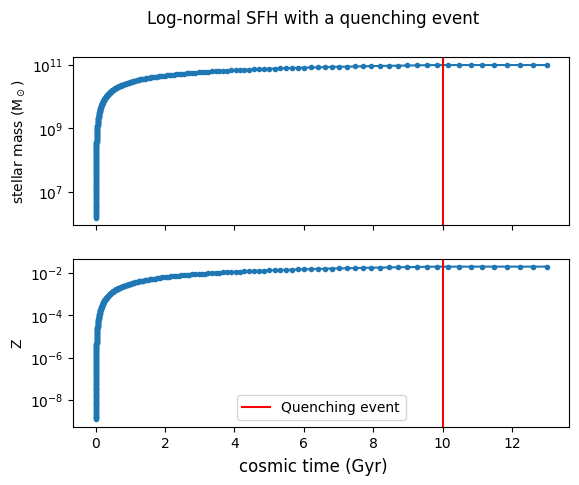

In [ ]:
cosmic_time = np.geomspace(1e-4, 1, 300) * today

fig, axes = plt.subplots(nrows=2, sharex=True)
fig.suptitle("Log-normal SFH with a quenching event")
fig.supxlabel(f"cosmic time ({cosmic_time.unit})")

ax = axes[0]
ax.set_ylabel(r"stellar mass (M$_\odot$)")
ax.set_yscale('log')
ax.plot(cosmic_time, model.stellar_mass_formed(cosmic_time), '.-')

ax = axes[1]
ax.set_ylabel(r"Z")
ax.set_yscale('log')
ax.plot(cosmic_time, model.ism_metallicity(cosmic_time), '.-')

for ax in axes:
    ax.axvline(quenching_time.to_value(cosmic_time.unit), color='r', label="Quenching event")

ax.legend()

## Spectral Energy Distribution

In [ ]:
ssp = PopStar(IMF='cha')
ssp.cut_wavelength(3000, 9000)

> Initialising Popstar models (IMF='cha')
--> Only stellar continuum
[SSP] Models cut between 3000.0 Angstrom 9000.0 Angstrom


Interpolate the CEM to the SSP ages and metallicities

In [ ]:
ssp_weights = model.interpolate_ssp_masses(ssp, t_obs=today)

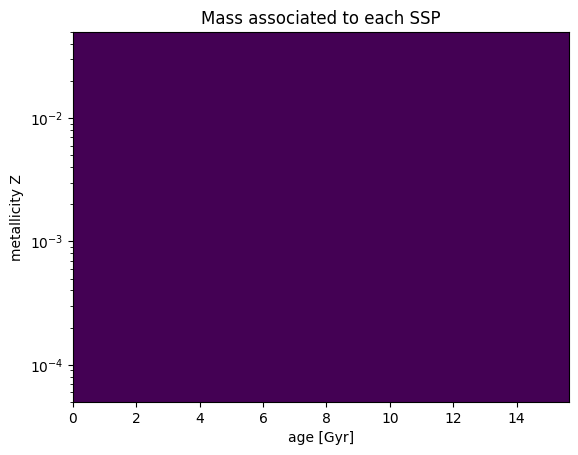

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f'Mass associated to each SSP')
ax.set_xlabel('age [Gyr]')
ax.set_ylabel('metallicity Z')
ax.set_yscale('log')
ax.set_ylim(5e-5, 0.05)

mappable = ax.pcolormesh(ssp.ages.to_value("Gyr"), ssp.metallicities, ssp_weights, norm=LogNorm())

#plt.colorbar(mappable, ax=ax, label=r"SSP mass (M$_\odot$)")

In [ ]:
np.max(ssp_weights)

<Quantity 0. solMass>

Finally, generate the associated spectrum

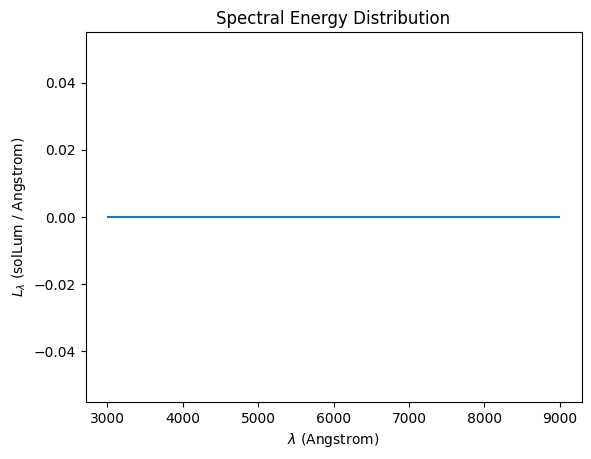

In [ ]:
sed = model.compute_SED(ssp, t_obs=today)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Spectral Energy Distribution')
ax.set_xlabel(r"$\lambda$ " + f"({ssp.wavelength.unit})")
ax.set_ylabel(r"$L_\lambda$ " + f"({sed.unit})")

ax.plot(ssp.wavelength, sed)